In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wandb
import wandb
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.python.framework import ops
import keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

In [9]:
model_saved = tf.keras.models.load_model(pathlib.Path('/content/drive/MyDrive/DL_Assignment2_PartA_Model')) #Loading the saved model
model_saved.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928 

In [10]:
###################################################
# Reading the test data
###################################################
test_data_dir = pathlib.Path('/content/drive/MyDrive/inaturalist_12K/val') # Set path to the right directory
test_data = tf.keras.preprocessing.image_dataset_from_directory(
                      directory = test_data_dir,
                      labels = 'inferred',  
                      label_mode = 'categorical',
                      color_mode = 'rgb',
                      batch_size = 32,
                      image_size = (256, 256),
                      shuffle = False,
                      seed = 17,
                      validation_split = 0)

print(len(test_data)) # Number of batches

Found 2000 files belonging to 10 classes.
63


In [7]:
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
# Defining a custom gradient for guided backpropogation
@tf.custom_gradient
def custom_relu(x):
    def grad(dy):
        return tf.nn.relu(dy)
    result = tf.nn.relu(x)
    return result, grad 

3 19


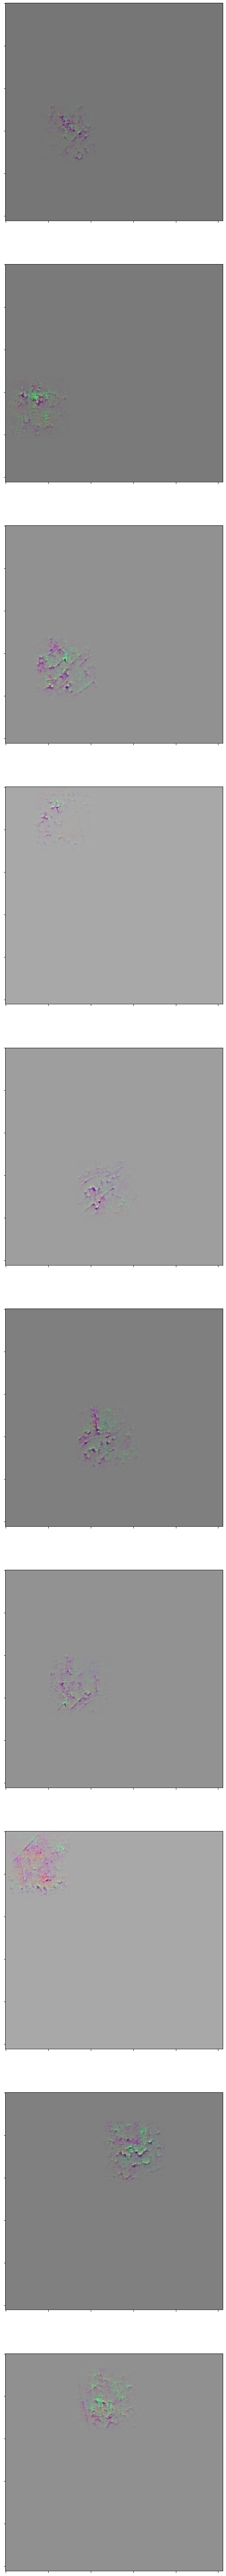

In [11]:
################################################
# Performing guided backpropogation
################################################
# Selecting a random image from the test dataset
batch_random, img_random = np.random.randint(5), np.random.randint(32) 
print(batch_random, img_random)
img_visualize = np.array((256, 256, 3), dtype=np.float64)
for batch_ind, (data, _) in enumerate(test_data):
    if batch_ind == batch_random:
        img_visualize = tf.convert_to_tensor(np.array(data[img_random,:,:,:], dtype = np.float64).reshape(1,256,256,3))
        break


fig, axs = plt.subplots(10, 1, figsize = (10, 100))
for count in range(10):
    with tf.GradientTape() as tape:
        tape.watch(tf.convert_to_tensor(img_visualize)) # Start recording the history of operations applied to the inputs
        x = Rescaling(scale = 1.0/255)(img_visualize)
        for layer in model_saved.layers[2:19]: # Building eager execution graph till 5th convolution layer
            x = layers.Lambda(custom_relu)(x) if 'activation' in layer.name else layer(x)

        ind1, ind2, ind3 = np.random.randint(10), np.random.randint(10), np.random.randint(10) # Selecting a random neuron
        guided_grad = tape.gradient(x[0,ind1,ind2,ind3], img_visualize) # Computing gradient wrt input layer
        img_arr = np.array((guided_grad-np.min(guided_grad))/(np.max(guided_grad)-np.min(guided_grad))).reshape(256,256,3)
        axs[count].imshow(img_arr)
        axs[count].set_yticklabels([])
        axs[count].set_xticklabels([])

wandb.log({'Guided Backpropogation': [wandb.Image(fig)]})
